# $\bm{28}$ $\enspace$ **批量归一化**

## $\bm{28.1}$ $\enspace$ **批量归一化**

从形式上说，用 $\bm{x}\in B$ 表示一个来自小批量 $B$ 的输入，批量归一化 $\mathrm{BN}$ 根据以下表达式转换 $\bm{x}$：
$$
    \mathrm{BN}(\bm{x})=\gamma \frac{\bm{x}-\hat{\mu}_B}{\hat{\sigma}_B}+\beta
$$
其中 $\hat{\mu}_B$ 是小批量 $B$ 的均值，$\hat{\sigma}_B$ 是小批量 $B$ 的样本标准差。我们需要去学习拉伸参数 $\gamma$ 及偏移参数 $\beta$。
$$
    \begin{split}
        \hat{\mu}_B&=\frac{1}{\vert B\vert}\sum_{\bm{x}\in B}\bm{x} \\
        \hat{\sigma}_B^2&=\frac{1}{\vert B\vert}\sum_{\bm{x}\in B}(\bm{x}-\hat{\mu}_B)^2+\epsilon 
    \end{split}
$$

## $\bm{28.2}$ $\enspace$ **从零实现**

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

创建一个正确的 `BatchNorm` 图层

In [2]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X,
            self.gamma,
            self.beta,
            self.moving_mean,
            self.moving_var,
            eps=1e-5,
            momentum=0.9,
        )
        return Y

## $\bm{28.3}$ $\enspace$ **使用批量规范化层的 LeNet**

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    BatchNorm(6, num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    BatchNorm(16, num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    BatchNorm(84, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84, 10),
)

loss 0.248, train acc 0.909, test acc 0.870
12368.5 examples/sec on cuda:0


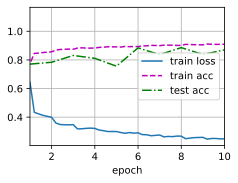

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

拉伸参数 `gamma` 和偏移参数 `beta`

In [5]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.8927, 1.2558, 1.8046, 1.3281, 2.1776, 2.2530], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.3526, -1.6096, -1.8071, -0.0364, -0.4565,  0.9189], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

## $\bm{28.4}$ $\enspace$ **简明实现**

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.BatchNorm2d(6),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(256, 120),
    nn.BatchNorm1d(120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.Sigmoid(),
    nn.Linear(84, 10),
)

loss 0.252, train acc 0.909, test acc 0.880
20010.8 examples/sec on cuda:0


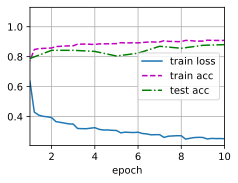

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())